# Explore here

PROYECTO SERIE TEMPORAL 2

In [42]:
import pandas as pd
import numpy as np
import os
import requests

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

from pmdarima import auto_arima

import warnings

In [43]:
warnings.filterwarnings("ignore")

In [44]:
df = pd.read_csv("/workspaces/Proyecto_serie_temp_2/data/raw/Aquifer_Petrignano.csv")

In [45]:
df.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,14/03/2006,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN
1,15/03/2006,NaN,-22.38,-22.14,NaN,NaN,NaN,NaN
2,16/03/2006,NaN,-22.25,-22.04,NaN,NaN,NaN,NaN
3,17/03/2006,NaN,-22.38,-22.04,NaN,NaN,NaN,NaN
4,18/03/2006,NaN,-22.60,-22.04,NaN,NaN,NaN,NaN


Date
Rainfall_Bastia_Umbra
Depth_to_Groundwater_P24
Depth_to_Groundwater_P25
Volume_C10_Petrignano
Hydrometry_Fiume_Chiascio_Petrignano

In [46]:
df['Date'] = pd.to_datetime(df.Date, format = '%d/%m/%Y')
df.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,2006-03-14,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN
1,2006-03-15,NaN,-22.38,-22.14,NaN,NaN,NaN,NaN
2,2006-03-16,NaN,-22.25,-22.04,NaN,NaN,NaN,NaN
3,2006-03-17,NaN,-22.38,-22.04,NaN,NaN,NaN,NaN
4,2006-03-18,NaN,-22.60,-22.04,NaN,NaN,NaN,NaN


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5223 entries, 0 to 5222
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Date                                  5223 non-null   datetime64[ns]
 1   Rainfall_Bastia_Umbra                 4199 non-null   float64       
 2   Depth_to_Groundwater_P24              5168 non-null   float64       
 3   Depth_to_Groundwater_P25              5184 non-null   float64       
 4   Temperature_Bastia_Umbra              4199 non-null   float64       
 5   Temperature_Petrignano                4199 non-null   float64       
 6   Volume_C10_Petrignano                 5025 non-null   float64       
 7   Hydrometry_Fiume_Chiascio_Petrignano  4199 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 326.6 KB


In [48]:
# Remove old rows
df = df[df.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True)
# Remove not usefull columns
df = df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis= 1)

In [50]:
# Simplify column names
df.columns = ['Date', 'Rainfall', 'Depth_to_Groundwater', 'Temperature', 'Drainage_Volume', 'River_Hydrometry']

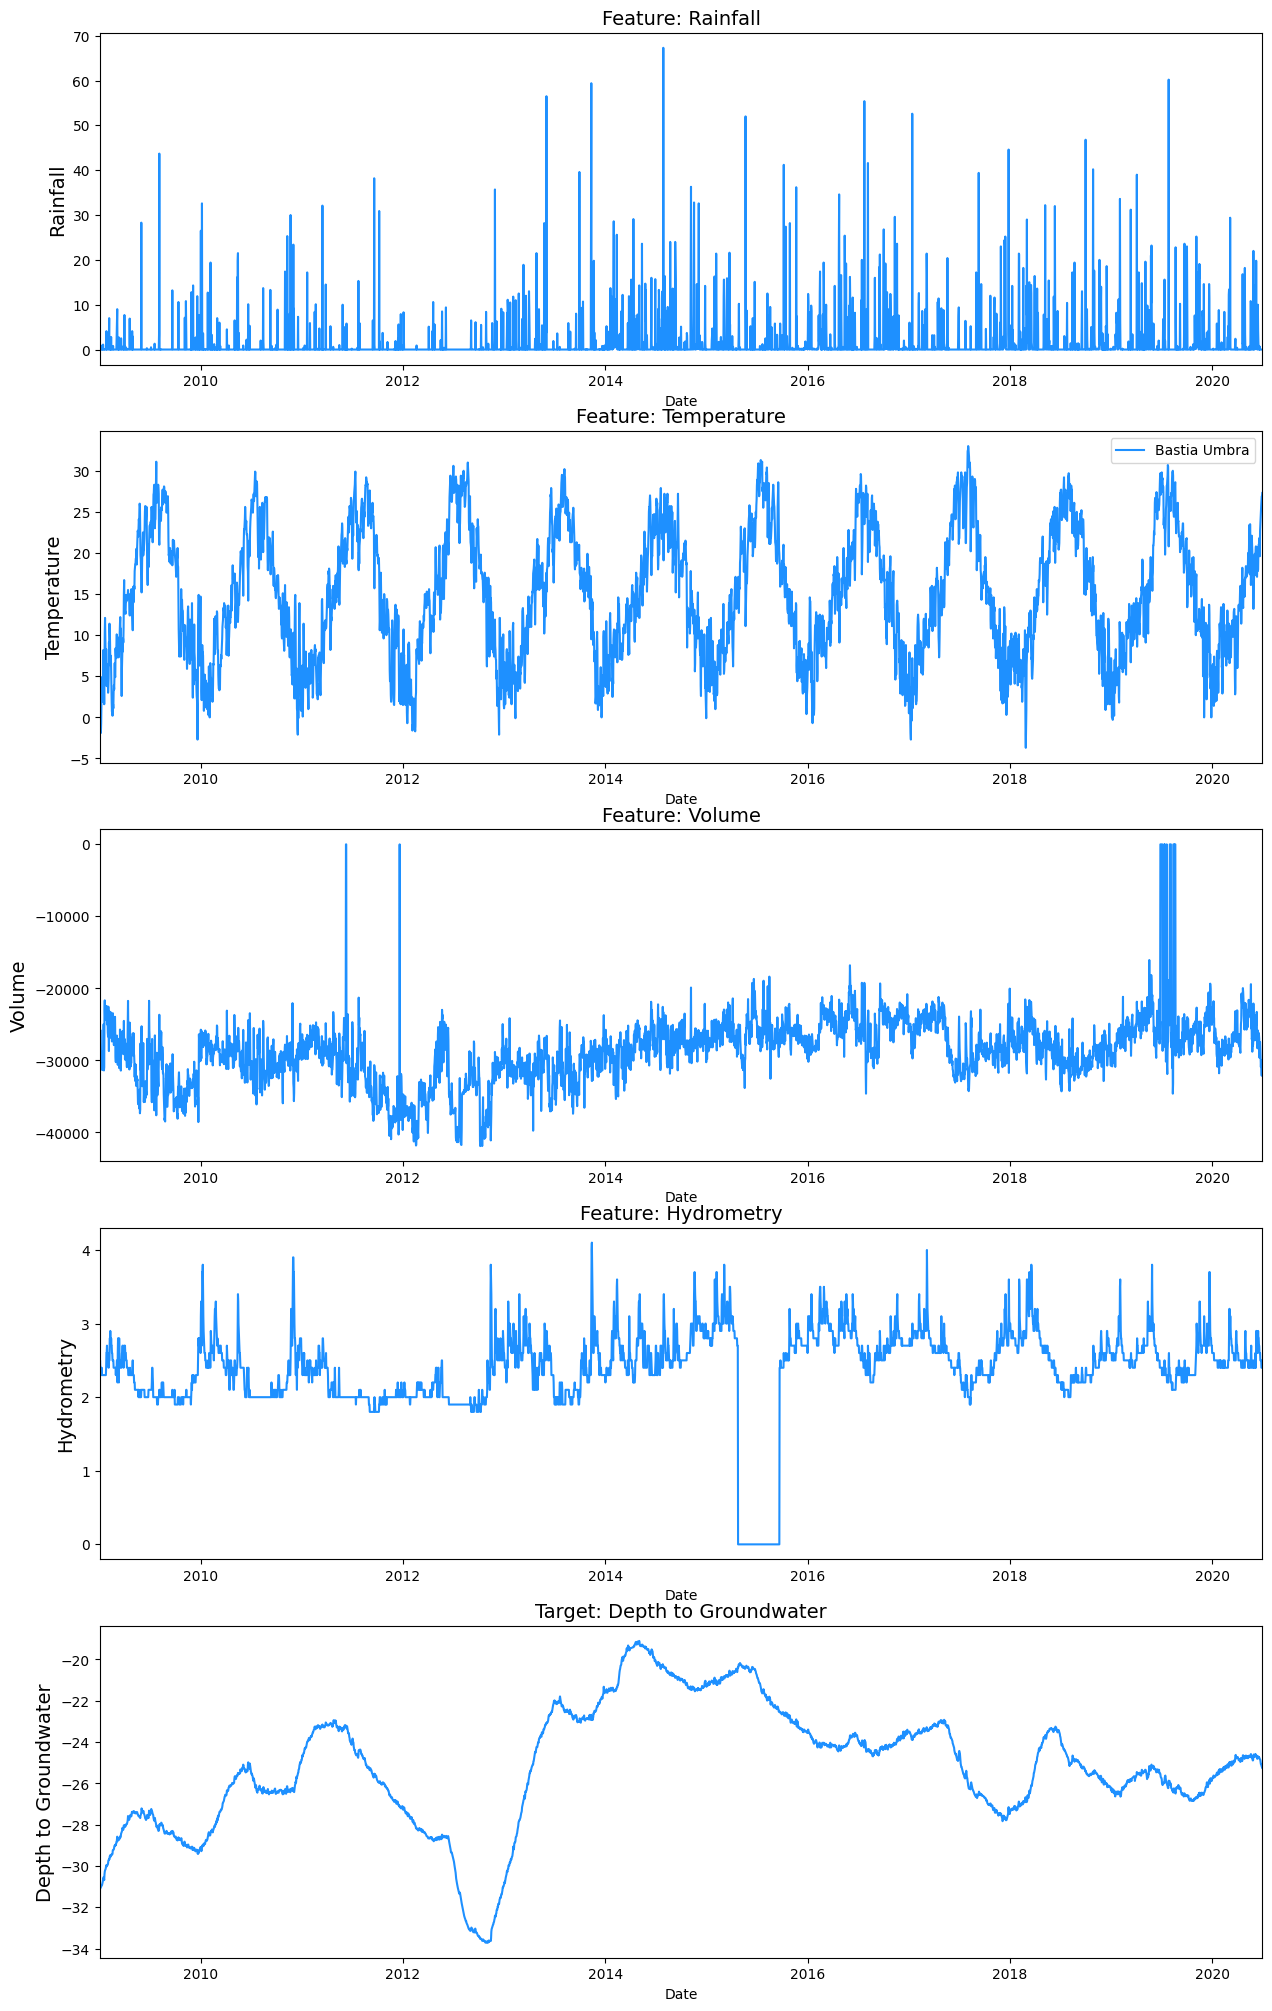

In [51]:
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 25))

sns.lineplot(x=df.Date, y=df.Rainfall.fillna(np.inf), ax=ax[0], color='dodgerblue')
ax[0].set_title('Feature: Rainfall', fontsize=14)
ax[0].set_ylabel(ylabel='Rainfall', fontsize=14)


sns.lineplot(x=df.Date, y=df.Temperature.fillna(np.inf), ax=ax[1], color='dodgerblue',label='Bastia Umbra')
ax[1].set_title('Feature: Temperature', fontsize=14)
ax[1].set_ylabel(ylabel='Temperature', fontsize=14)


sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(np.inf), ax=ax[2], color='dodgerblue')
ax[2].set_title('Feature: Volume', fontsize=14)
ax[2].set_ylabel(ylabel='Volume', fontsize=14)


sns.lineplot(x=df.Date, y=df.River_Hydrometry.fillna(np.inf), ax=ax[3], color='dodgerblue')
ax[3].set_title('Feature: Hydrometry', fontsize=14)
ax[3].set_ylabel(ylabel='Hydrometry', fontsize=14)


sns.lineplot(x=df.Date, y=df.Depth_to_Groundwater.fillna(np.inf), ax=ax[4], color='dodgerblue')
ax[4].set_title('Target: Depth to Groundwater', fontsize=14)
ax[4].set_ylabel(ylabel='Depth to Groundwater', fontsize=14)


for i in range(5):
    ax[i].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

plt.show()

In [52]:
# Sort values by timestamp (not necessary in this case)
df = df.sort_values(by='Date')

# Check time intervals
df['Time_Interval'] = df.Date - df.Date.shift(1)

df[['Date', 'Time_Interval']].head()

,Date,Time_Interval
0,2009-01-01,NaT
1,2009-01-02,1 days
2,2009-01-03,1 days
3,2009-01-04,1 days
4,2009-01-05,1 days


In [53]:
print(f"{df['Time_Interval'].value_counts()}")
df = df.drop('Time_Interval', axis=1)

Time_Interval
1 days    4198
Name: count, dtype: int64


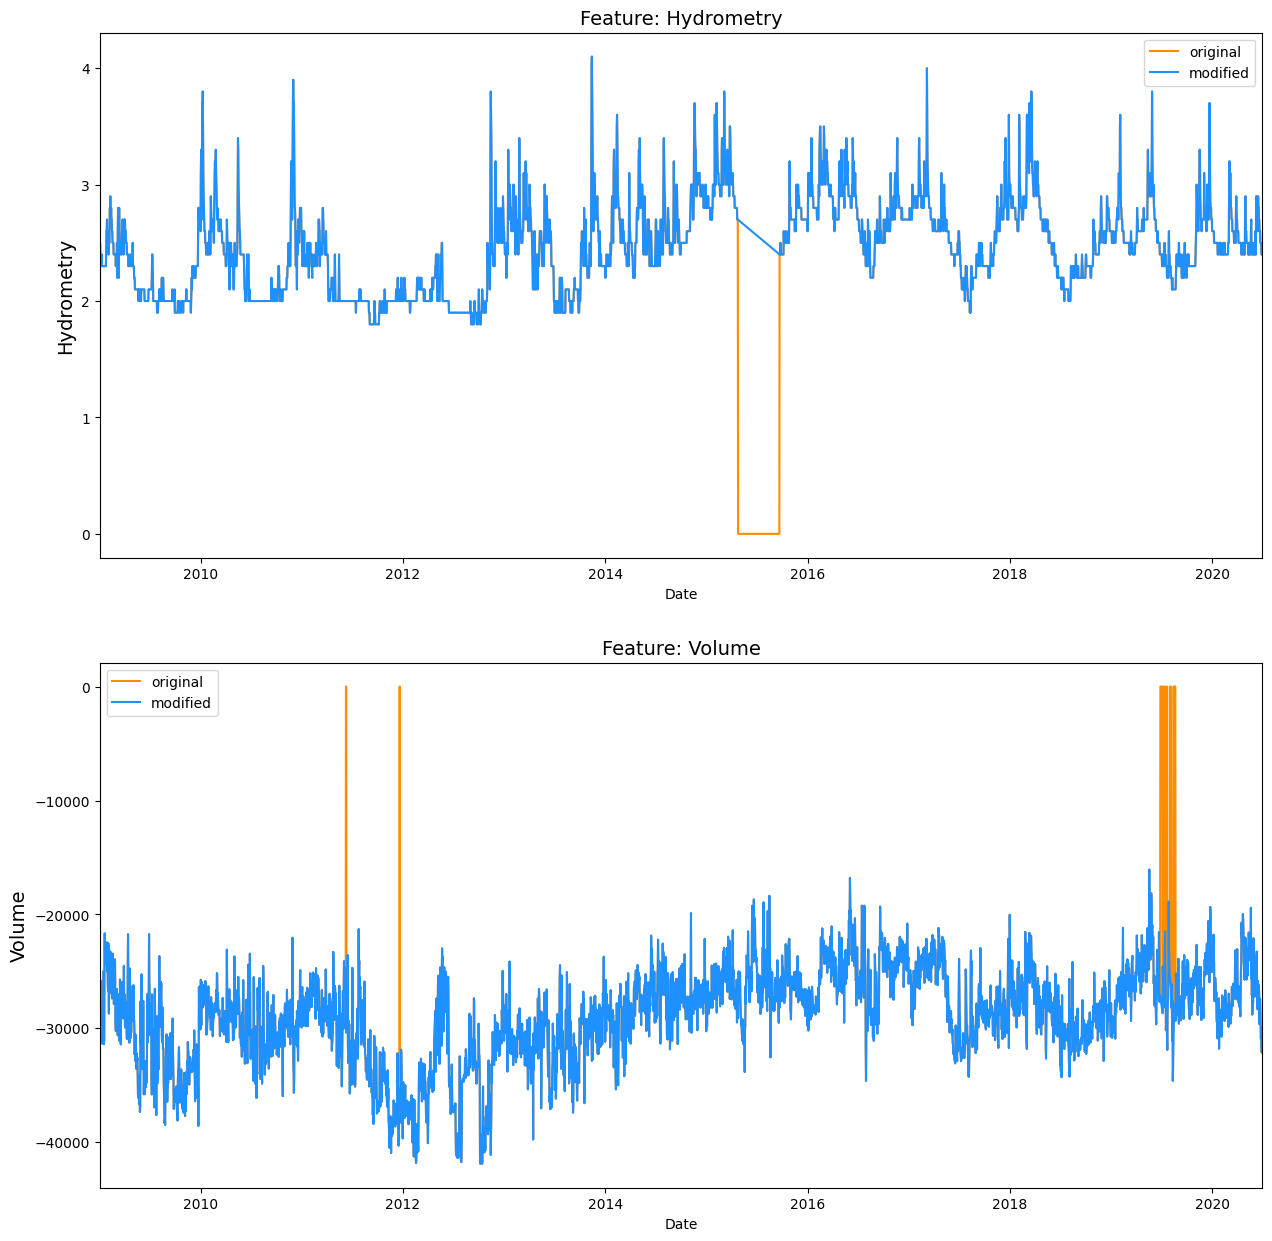

In [55]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
old = df.River_Hydrometry.copy()
df['River_Hydrometry'] = np.where((df.River_Hydrometry == 0),np.nan, df.River_Hydrometry)

sns.lineplot(x=df.Date, y=old.fillna(np.inf), ax=ax[0], color='darkorange', label = 'original')
sns.lineplot(x=df.Date, y=df.River_Hydrometry.fillna(np.inf), ax=ax[0], color='dodgerblue', label = 'modified')
ax[0].set_title('Feature: Hydrometry', fontsize=14)
ax[0].set_ylabel(ylabel='Hydrometry', fontsize=14)

old = df.Drainage_Volume.copy()
df['Drainage_Volume'] = np.where((df.Drainage_Volume == 0),np.nan, df.Drainage_Volume)

sns.lineplot(x=df.Date, y=old.fillna(np.inf), ax=ax[1], color='darkorange', label = 'original')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(np.inf), ax=ax[1], color='dodgerblue', label = 'modified')
ax[1].set_title('Feature: Volume', fontsize=14)
ax[1].set_ylabel(ylabel='Volume', fontsize=14)


for i in range(2):
    ax[i].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

plt.show()


NameError: name 'Date' is not defined

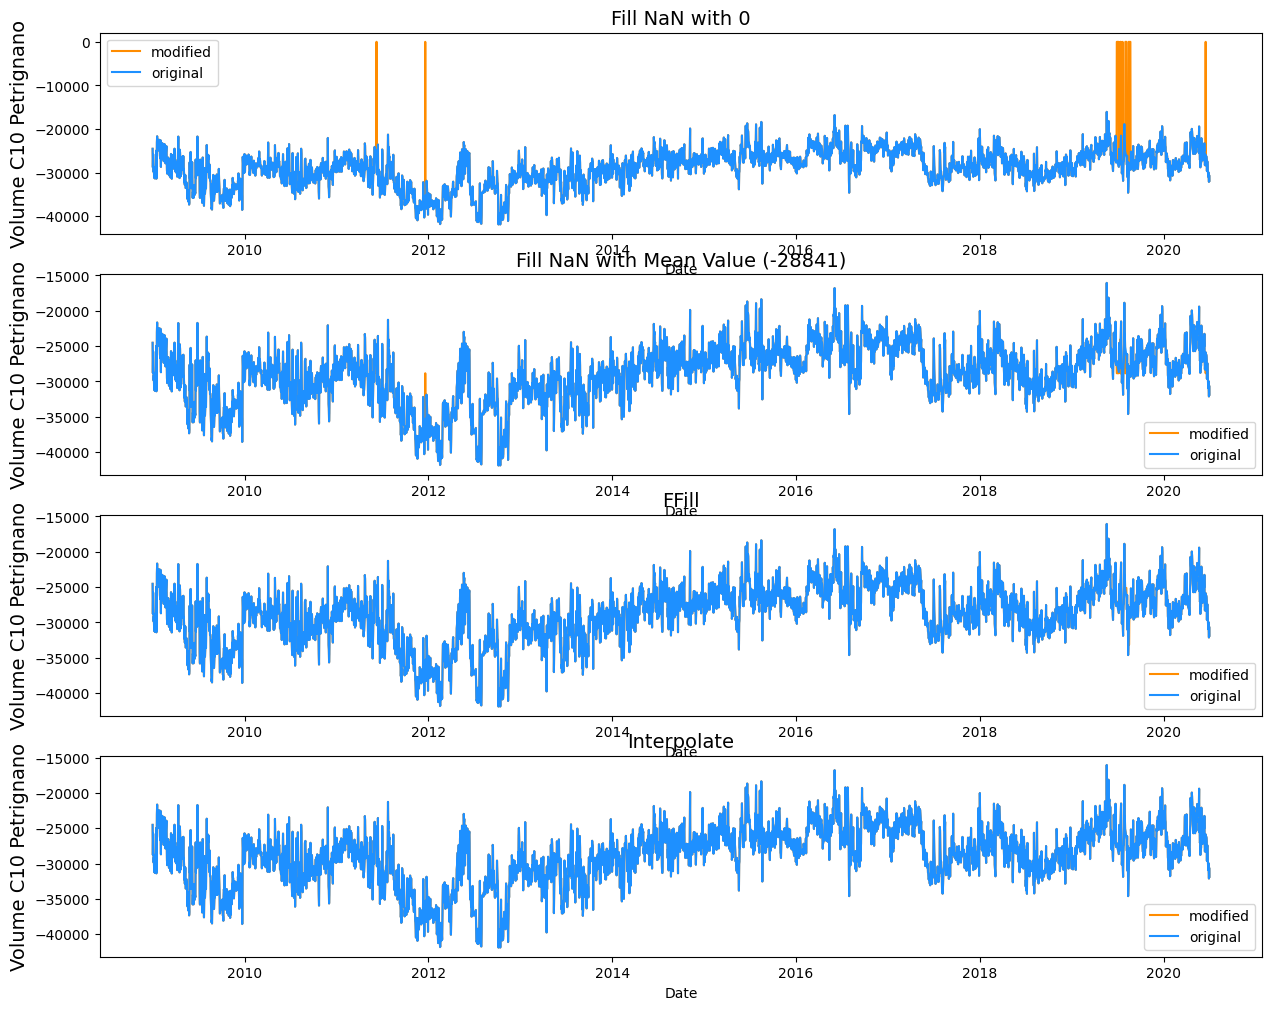

In [59]:
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 12))

sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(0), ax=ax[0], color='darkorange', label = 'modified')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(np.inf), ax=ax[0], color='dodgerblue', label = 'original')
ax[0].set_title('Fill NaN with 0', fontsize=14)
ax[0].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

mean_val = df.Drainage_Volume.mean()
sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(mean_val), ax=ax[1], color='darkorange', label = 'modified')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(np.inf), ax=ax[1], color='dodgerblue', label = 'original')
ax[1].set_title(f'Fill NaN with Mean Value ({mean_val:.0f})', fontsize=14)
ax[1].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

sns.lineplot(x=df.Date, y=df.Drainage_Volume.ffill(), ax=ax[2], color='darkorange', label = 'modified')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(np.inf), ax=ax[2], color='dodgerblue', label = 'original')
ax[2].set_title(f'FFill', fontsize=14)
ax[2].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

sns.lineplot(x=df.Date, y=df.Drainage_Volume.interpolate(), ax=ax[3], color='darkorange', label = 'modified')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(np.inf), ax=ax[3], color='dodgerblue', label = 'original')
ax[3].set_title(f'Interpolate', fontsize=14)
ax[3].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

for i in range(4):
    ax[i].set_xlim([date(2019, 5, 1), date(2019, 10, 1)])
plt.tight_layout()
plt.show()
